# CERN & Particle physics: Discrimination of positron/photon/pion showers in EM calorimeter

### Step 1: Frame the problem
Datasett link: https://zenodo.org/record/573298#.Y-n-mXaZNtZ
Given the hdf5 file that have a following structure:
energy    Dataset {100000, 1}
layer_0   Dataset {100000, 3, 96}
layer_1   Dataset {100000, 12, 12}
layer_2   Dataset {100000, 12, 6}
overflow  Dataset {100000, 3}
In practice, each file is a collection of 100,000 calorimeter showers corresponding to the particle specified in the file name (eplus = positrons, gamma = photons, piplus = charged pions).

The calorimeter we built is segmented longitudinally into three layer with different depths and granularities. In units of mm, the three layers have the following (eta, phi, z) dimensions:
Layer 0: (5, 160, 90) | Layer 1: (40, 40, 347) | Layer 2: (80, 40, 43)

In the HDF5 files, the `energy` entry specifies the true energy of the incoming particle in units of GeV. `layer_0`, `layer_1`, and `layer_2` represents the energy deposited in each layer of the calorimeter in an image data format. Given the segmentation of each calorimeter layer, these images have dimensions 3x96 (in layer 0), 12x12 (in layer 1), and 12x6 (in layer 3). The `overflow` contains the amount of energy that was deposited outside of the calorimeter section we are considering.

Train classifier based on image recognition. Utilize 3D information.
Convert data arrays into suitable image format. Train CNN. Each event consist of three data/image layers - investigate how this can be treated. 

### Step 2: Set up enviroment, import data

Import necessary libraries

In [1]:
import numpy as np
import h5py
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from skimage.transform import resize

In [2]:
# Code below can show waht are different columns existing in one hdf5 file
filename = "eplus.hdf5"

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key])) 

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])

    # If a_group_key is a dataset name, 
    # this gets the dataset values and returns as a list
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array

Keys: <KeysViewHDF5 ['energy', 'layer_0', 'layer_1', 'layer_2', 'overflow']>
<class 'h5py._hl.dataset.Dataset'>


Create pngs?
Read the hdf5 file and store each of the image layers as pngs subfolders named by particle name
get kind of particle
dir to store the calorimeter
load and store the images from hdf5


In [4]:
##def create_pngs(fn):
    

Create RGB images
Create form three channels

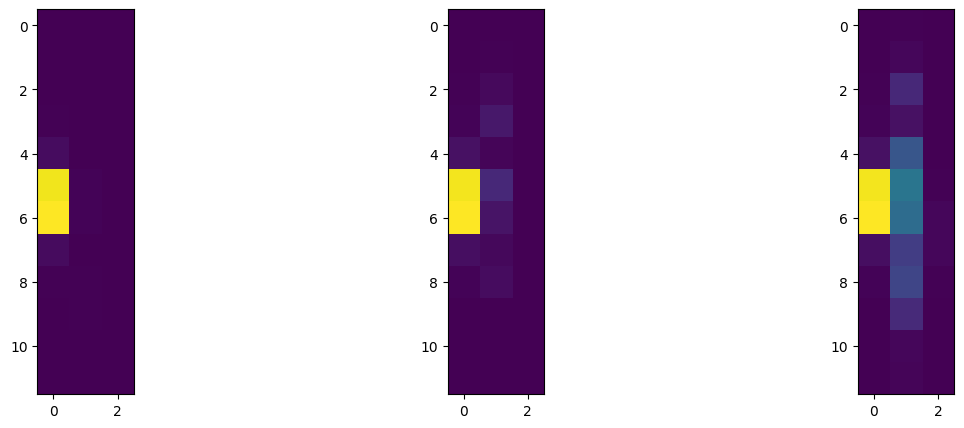

In [5]:
with h5py.File("eplus.hdf5", "r") as f:
    energy = f['energy'][:]
    layer_0 = f['layer_0'][:]
    layer_1 = f['layer_1'][:]
    layer_2 = f['layer_2'][:]
    overflow = f['overflow'][:]

layer_0_resized = np.array([resize(layer_0[i], (12, 12)) for i in range(layer_0.shape[0])])

layer_2_resized = np.array([resize(layer_2[i], (12, 12)) for i in range(layer_2.shape[0])])
   
images = np.concatenate([layer_0_resized[..., np.newaxis],
                        layer_1[..., np.newaxis],
                        layer_2_resized[..., np.newaxis]], axis=-1)

sample_image = images[0]

fid, ax = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))
for i in range(3):
    ax[i].imshow(sample_image[i])
    
plt.show()

New code